<a href="https://colab.research.google.com/github/dilgc/Credit-Card-Fraud-/blob/main/Isolation_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isolation Forests and LightGBM
## Charles Dilger


---



The goal of this notebook is to compare Isolation Forests to LightGBM in the case of detecting credit card fraud. Both Isolation Forests and LightGBM have been shown to perform excellently within the subject. However, LightGBM outperformed Isolation Forest in the one instance it was tested. The goal is to confirm whether or not LightGBM actually outperforms Isolation Forests. In order to do this, we will use 3 credit card fraud databases, and test Isolation Forests against LightGBM 3 times.

We will begin with our first dataset, the most popular credit card fraud dataset on Kaggle. It can be accessed at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download.

Let's now load the dataset, and make sure we can read from it. The dataset has a quarter of a million rows, which is excessive considering the supermajority are not fraud. We will include all fraudulent rows, and restrict the size to 10,000 so that we have a nice, representative subset.

In [ ]:
# Install kaggle package
!pip install -q kaggle

# Upload your kaggle.json file (you'll be prompted to upload)
from google.colab import files
files.upload()  # Upload your kaggle.json here

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip the dataset
!unzip -q creditcardfraud.zip

# Load and view the data
import pandas as pd

df = pd.read_csv('creditcard.csv')
print(f"Original dataset shape: {df.shape}")

# Separate fraud and non-fraud cases
fraud_cases = df[df['Class'] == 1]
non_fraud_cases = df[df['Class'] == 0]

print(f"Total fraud cases: {len(fraud_cases)}")
print(f"Total non-fraud cases: {len(non_fraud_cases)}")

# Keep all fraud cases and fill up to 10,000 with non-fraud cases
remaining_slots = 10000 - len(fraud_cases)
df = pd.concat([fraud_cases, non_fraud_cases.head(remaining_slots)], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTrimmed dataset shape: {df.shape}")
print(f"Fraud cases in trimmed dataset: {df['Class'].sum()}")
print(f"Fraud percentage: {df['Class'].sum() / len(df) * 100:.2f}%")
print(f"\nFirst 5 rows:")
df.head()

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
Original dataset shape: (284807, 31)
Total fraud cases: 492
Total non-fraud cases: 284315

Trimmed dataset shape: (10000, 31)
Fraud cases in trimmed dataset: 492
Fraud percentage: 4.92%

First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,6142.0,-1.086170,-1.380562,3.000680,-2.507938,-1.542000,1.100609,-1.148362,0.623731,0.419572,...,-0.218438,-0.047855,-0.058457,-0.436209,0.408404,-0.289013,0.027177,0.046973,108.00,0
1,3750.0,0.883178,-1.244905,0.286097,-0.505037,-0.940879,0.053781,-0.559700,0.011518,0.352708,...,-0.051488,-0.604315,-0.078530,-0.391221,0.034587,-0.510687,-0.054542,0.039569,248.59,0
2,957.0,-0.922509,0.480399,2.091886,1.646377,-0.512384,0.229682,0.630477,-0.591026,0.705361,...,0.113923,0.906466,-0.295780,0.442751,-0.324682,-0.153798,-0.826676,-0.028785,84.95,0
3,3754.0,-2.116438,-1.844152,2.362654,-1.009384,1.410695,-2.000374,-1.323538,0.169793,0.116289,...,0.020676,-0.574290,0.353871,0.264463,0.164202,-0.590737,-0.069552,0.097483,19.63,0
4,3670.0,-0.997411,0.308922,2.098348,-0.672282,0.927175,-1.278994,0.716706,-0.300129,1.060173,...,-0.232219,-0.521714,0.183394,0.516041,-0.509787,-0.347719,-0.145652,-0.082397,13.99,0


The biggest issue we struggle from with this data is the class imbalance. This likely won't be an issue with Isolation Forests, but it will become an issue with LightGBM which may have a bias towards the majority class. In order to address this straightaway, we will run SMOTE.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Check for missing values
print("Missing values:")
print(df.isnull().sum().sum())

# Check class distribution
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {df['Class'].sum() / len(df) * 100:.2f}%")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data (80-20 split, stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nBefore SMOTE:")
print(f"Training set size: {X_train.shape}")
print(f"Fraud cases in train: {y_train.sum()}")

# Apply SMOTE to training data only (never to test data!)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training set size: {X_train_smote.shape}")
print(f"Fraud cases in train: {y_train_smote.sum()}")
print(f"Class distribution: {np.bincount(y_train_smote)}")

print(f"\nTest set (unchanged): {X_test.shape}")
print(f"Fraud cases in test: {y_test.sum()}")

# Optional: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing complete!")
print("Use X_train_smote and y_train_smote for training supervised models")

Missing values:
0

Class distribution:
Class
0    9508
1     492
Name: count, dtype: int64

Fraud percentage: 4.92%

Before SMOTE:
Training set size: (8000, 30)
Fraud cases in train: 394

After SMOTE:
Training set size: (15212, 30)
Fraud cases in train: 7606
Class distribution: [7606 7606]

Test set (unchanged): (2000, 30)
Fraud cases in test: 98

Data preprocessing complete!
Use X_train_smote and y_train_smote for training supervised models


Great, the classes are now more balanced. The model is already ready for Isolation Forests.

Training Isolation Forest...

ISOLATION FOREST RESULTS

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.98      0.98      1902
       Fraud       0.65      0.65      0.65        98

    accuracy                           0.97      2000
   macro avg       0.81      0.82      0.82      2000
weighted avg       0.97      0.97      0.97      2000


Confusion Matrix:
[[1867   35]
 [  34   64]]

ROC-AUC Score: 0.9652


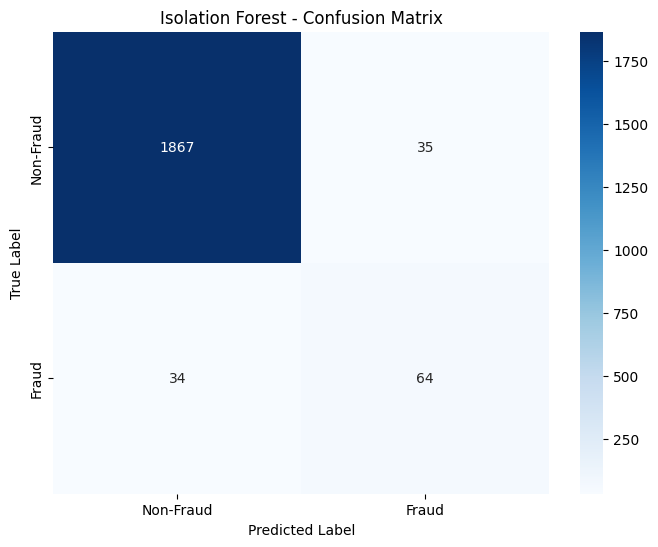

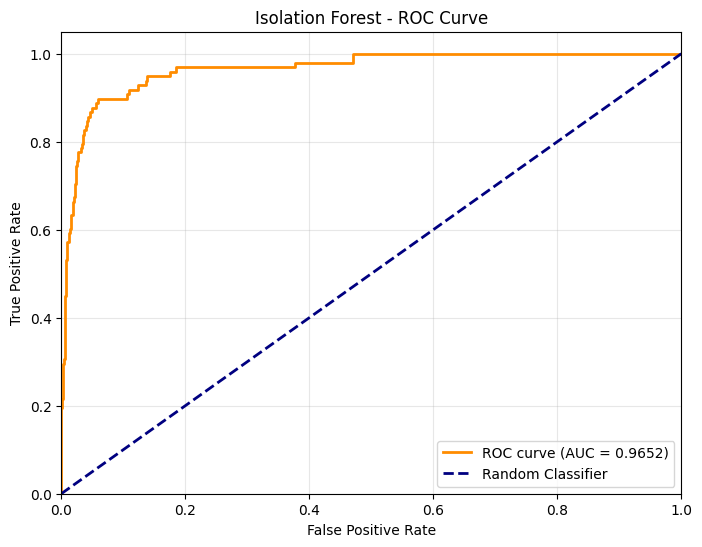


Isolation Forest training and evaluation complete!


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train Isolation Forest (unsupervised - uses X_train only, not y_train)
print("Training Isolation Forest...")
iso_forest = IsolationForest(
    n_estimators=100,           # Number of trees
    contamination=0.05,         # Expected proportion of outliers (5% is close to our 4.92%)
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

# Fit on training data (no labels needed)
iso_forest.fit(X_train)

# Predict on test data (-1 for anomaly/fraud, 1 for normal)
y_pred_iso = iso_forest.predict(X_test)

# Convert predictions: -1 (anomaly) -> 1 (fraud), 1 (normal) -> 0 (non-fraud)
y_pred_iso = (y_pred_iso == -1).astype(int)

# Get anomaly scores for ROC-AUC (lower score = more anomalous)
anomaly_scores = iso_forest.decision_function(X_test)
# Invert scores so higher = more likely fraud
y_scores_iso = -anomaly_scores

print("\n" + "="*50)
print("ISOLATION FOREST RESULTS")
print("="*50)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_iso, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_iso)
print(cm)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_scores_iso)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Isolation Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_iso)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Isolation Forest - ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("\nIsolation Forest training and evaluation complete!")

Interesting, it performed fairly well. Let's take a deeper look at metrics. We will look at Accuracy, Precision, Recall, F1-Score,
ROC-AUC, Matthews Correlation Coefficient (MCC),
Confusion Matrix with all components. We will also take a look at a few visualizations. We'll get a good idea of how the Isolation Forest performed.

Training Isolation Forest with statistical analysis...

ISOLATION FOREST RESULTS WITH STATISTICAL ANALYSIS

--- Basic Performance Metrics ---
Accuracy:  0.9655
Precision: 0.6465
Recall:    0.6531
F1-Score:  0.6497
ROC-AUC:   0.9652
MCC:       0.6316

--- Cross-Validation Analysis (5-Fold) ---
Accuracy: 0.9692 ± 0.0043 (95% CI: [0.9633, 0.9752])
Precision: 0.6879 ± 0.0497 (95% CI: [0.6189, 0.7569])
Recall: 0.6929 ± 0.0597 (95% CI: [0.6099, 0.7758])
F1-Score: 0.6890 ± 0.0444 (95% CI: [0.6274, 0.7506])
ROC-AUC: 0.9750 ± 0.0050 (95% CI: [0.9680, 0.9820])

--- Statistical Significance Tests ---
T-test (Fraud vs Normal scores):
  t-statistic: 38.5888
  p-value: 6.4478e-244
  Significant at α=0.05: Yes

Cohen's d (Effect Size): 3.9972
  Interpretation: large effect

--- Confusion Matrix ---
[[1867   35]
 [  34   64]]
True Negatives:  1867
False Positives: 35
False Negatives: 34
True Positives:  64


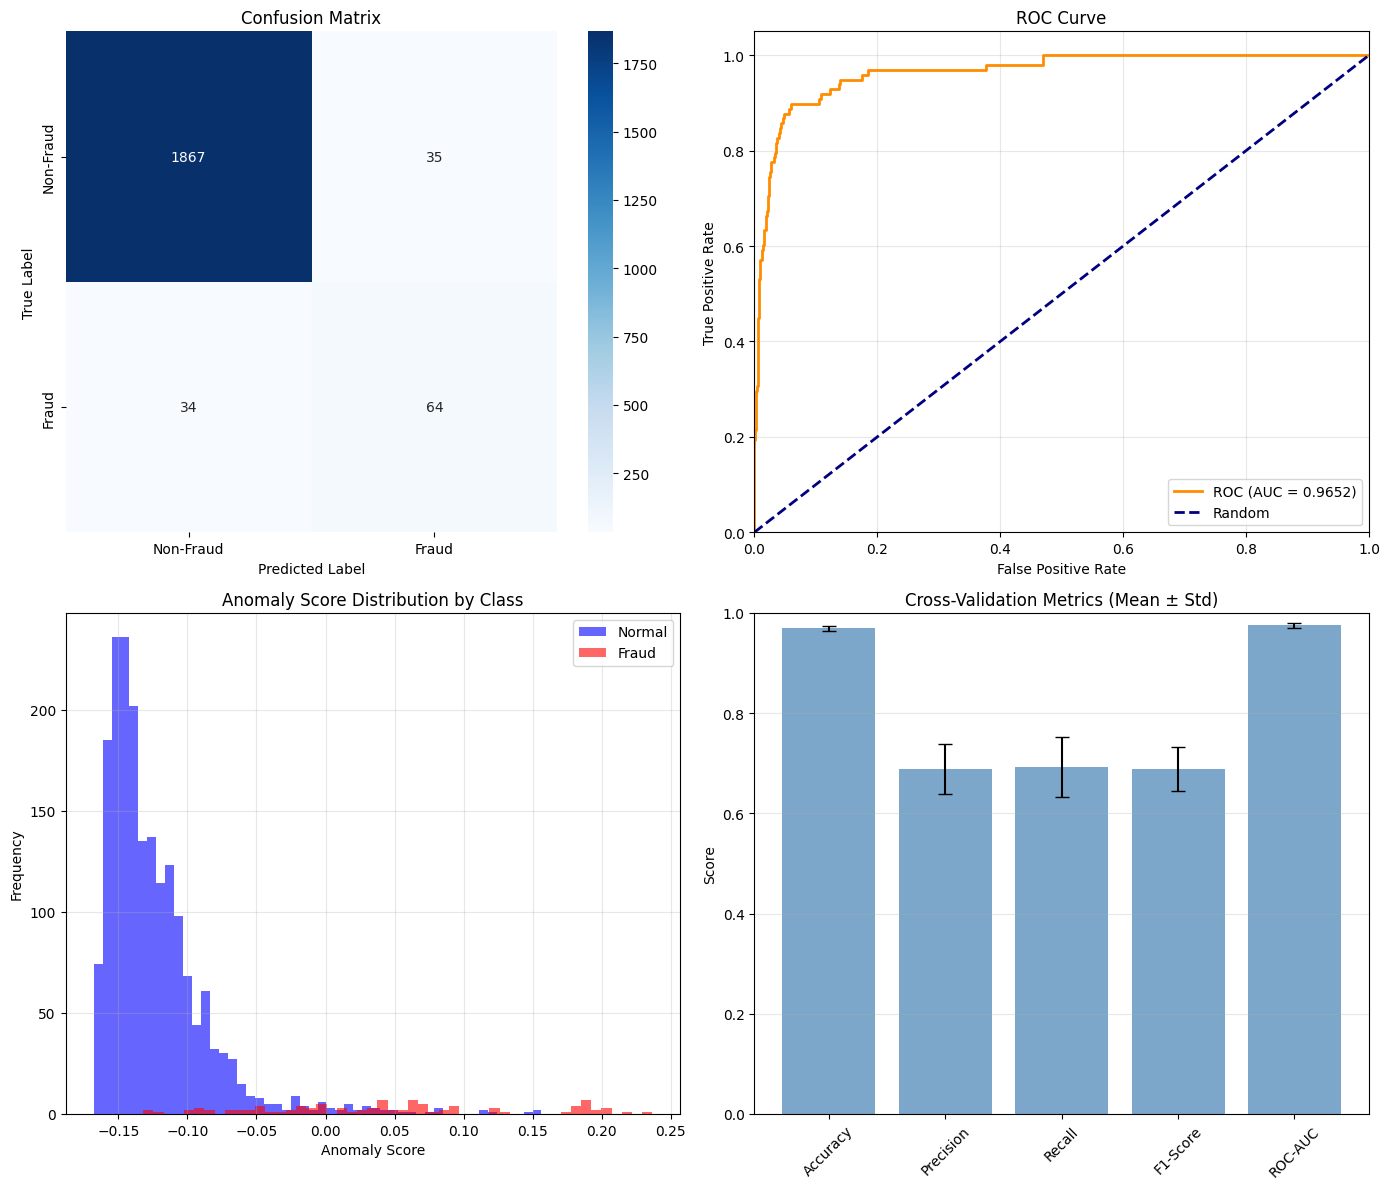


Isolation Forest evaluation complete with statistical analysis!


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def calculate_confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for a dataset"""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - ci, mean + ci

def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# Train Isolation Forest
print("Training Isolation Forest with statistical analysis...")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
iso_forest.fit(X_train)

# Predict on test data
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = (y_pred_iso == -1).astype(int)

# Get anomaly scores
anomaly_scores = iso_forest.decision_function(X_test)
y_scores_iso = -anomaly_scores

print("\n" + "="*70)
print("ISOLATION FOREST RESULTS WITH STATISTICAL ANALYSIS")
print("="*70)

# ========== BASIC METRICS ==========
print("\n--- Basic Performance Metrics ---")
accuracy = accuracy_score(y_test, y_pred_iso)
precision = precision_score(y_test, y_pred_iso, zero_division=0)
recall = recall_score(y_test, y_pred_iso, zero_division=0)
f1 = f1_score(y_test, y_pred_iso, zero_division=0)
roc_auc = roc_auc_score(y_test, y_scores_iso)
mcc = matthews_corrcoef(y_test, y_pred_iso)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"MCC:       {mcc:.4f}")

# ========== CROSS-VALIDATION WITH CONFIDENCE INTERVALS ==========
print("\n--- Cross-Validation Analysis (5-Fold) ---")

# For unsupervised models, we evaluate prediction quality
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_auc = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model
    iso_cv = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso_cv.fit(X_cv_train)

    # Predict
    y_pred_cv = (iso_cv.predict(X_cv_val) == -1).astype(int)
    y_scores_cv = -iso_cv.decision_function(X_cv_val)

    # Calculate metrics
    cv_scores.append(accuracy_score(y_cv_val, y_pred_cv))
    cv_precision.append(precision_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_recall.append(recall_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_f1.append(f1_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_auc.append(roc_auc_score(y_cv_val, y_scores_cv))

# Calculate confidence intervals
metrics = {
    'Accuracy': cv_scores,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1,
    'ROC-AUC': cv_auc
}

for metric_name, values in metrics.items():
    mean, lower, upper = calculate_confidence_interval(values)
    std = np.std(values)
    print(f"{metric_name}: {mean:.4f} ± {std:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")

# ========== STATISTICAL SIGNIFICANCE TESTS ==========
print("\n--- Statistical Significance Tests ---")

# Separate scores by true class
fraud_scores = y_scores_iso[y_test == 1]
normal_scores = y_scores_iso[y_test == 0]

# t-test: Are fraud and normal scores significantly different?
t_stat, p_value = stats.ttest_ind(fraud_scores, normal_scores)
print(f"T-test (Fraud vs Normal scores):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Cohen's d: Effect size
cohens_d = calculate_cohens_d(fraud_scores, normal_scores)
print(f"\nCohen's d (Effect Size): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect = "negligible"
elif abs(cohens_d) < 0.5:
    effect = "small"
elif abs(cohens_d) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"  Interpretation: {effect} effect")

# ========== CONFUSION MATRIX ==========
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_iso)
print(cm)
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# ========== VISUALIZATIONS ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores_iso)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(alpha=0.3)

# 3. Score Distribution
axes[1,0].hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='blue')
axes[1,0].hist(fraud_scores, bins=50, alpha=0.6, label='Fraud', color='red')
axes[1,0].set_xlabel('Anomaly Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Anomaly Score Distribution by Class')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Cross-Validation Metrics with Error Bars
metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]
axes[1,1].bar(metric_names, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Cross-Validation Metrics (Mean ± Std)')
axes[1,1].set_ylim([0, 1])
axes[1,1].grid(alpha=0.3, axis='y')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Isolation Forest evaluation complete with statistical analysis!")
print("="*70)

The model perfomed well, but we will have to see if LightGBM performs better. Let's run LightGBM with the same comprehensive analysis.

Training LightGBM with statistical analysis...

LIGHTGBM RESULTS WITH STATISTICAL ANALYSIS

--- Basic Performance Metrics ---
Accuracy:  0.9990
Precision: 0.9800
Recall:    1.0000
F1-Score:  0.9899
ROC-AUC:   1.0000
MCC:       0.9894

--- Cross-Validation Analysis (5-Fold) ---
Accuracy: 0.9997 ± 0.0002 (95% CI: [0.9994, 1.0001])
Precision: 0.9996 ± 0.0003 (95% CI: [0.9992, 1.0001])
Recall: 0.9999 ± 0.0003 (95% CI: [0.9995, 1.0002])
F1-Score: 0.9997 ± 0.0002 (95% CI: [0.9994, 1.0001])
ROC-AUC: 1.0000 ± 0.0000 (95% CI: [1.0000, 1.0000])

--- Statistical Significance Tests ---
T-test (Fraud vs Normal predicted probabilities):
  t-statistic: 401.8760
  p-value: 0.0000e+00
  Significant at α=0.05: Yes

Cohen's d (Effect Size): 41.6283
  Interpretation: large effect

--- Confusion Matrix ---
[[1900    2]
 [   0   98]]
True Negatives:  1900
False Positives: 2
False Negatives: 0
True Positives:  98

--- Top 10 Most Important Features ---
Feature  Importance
   Time         308
    V14         

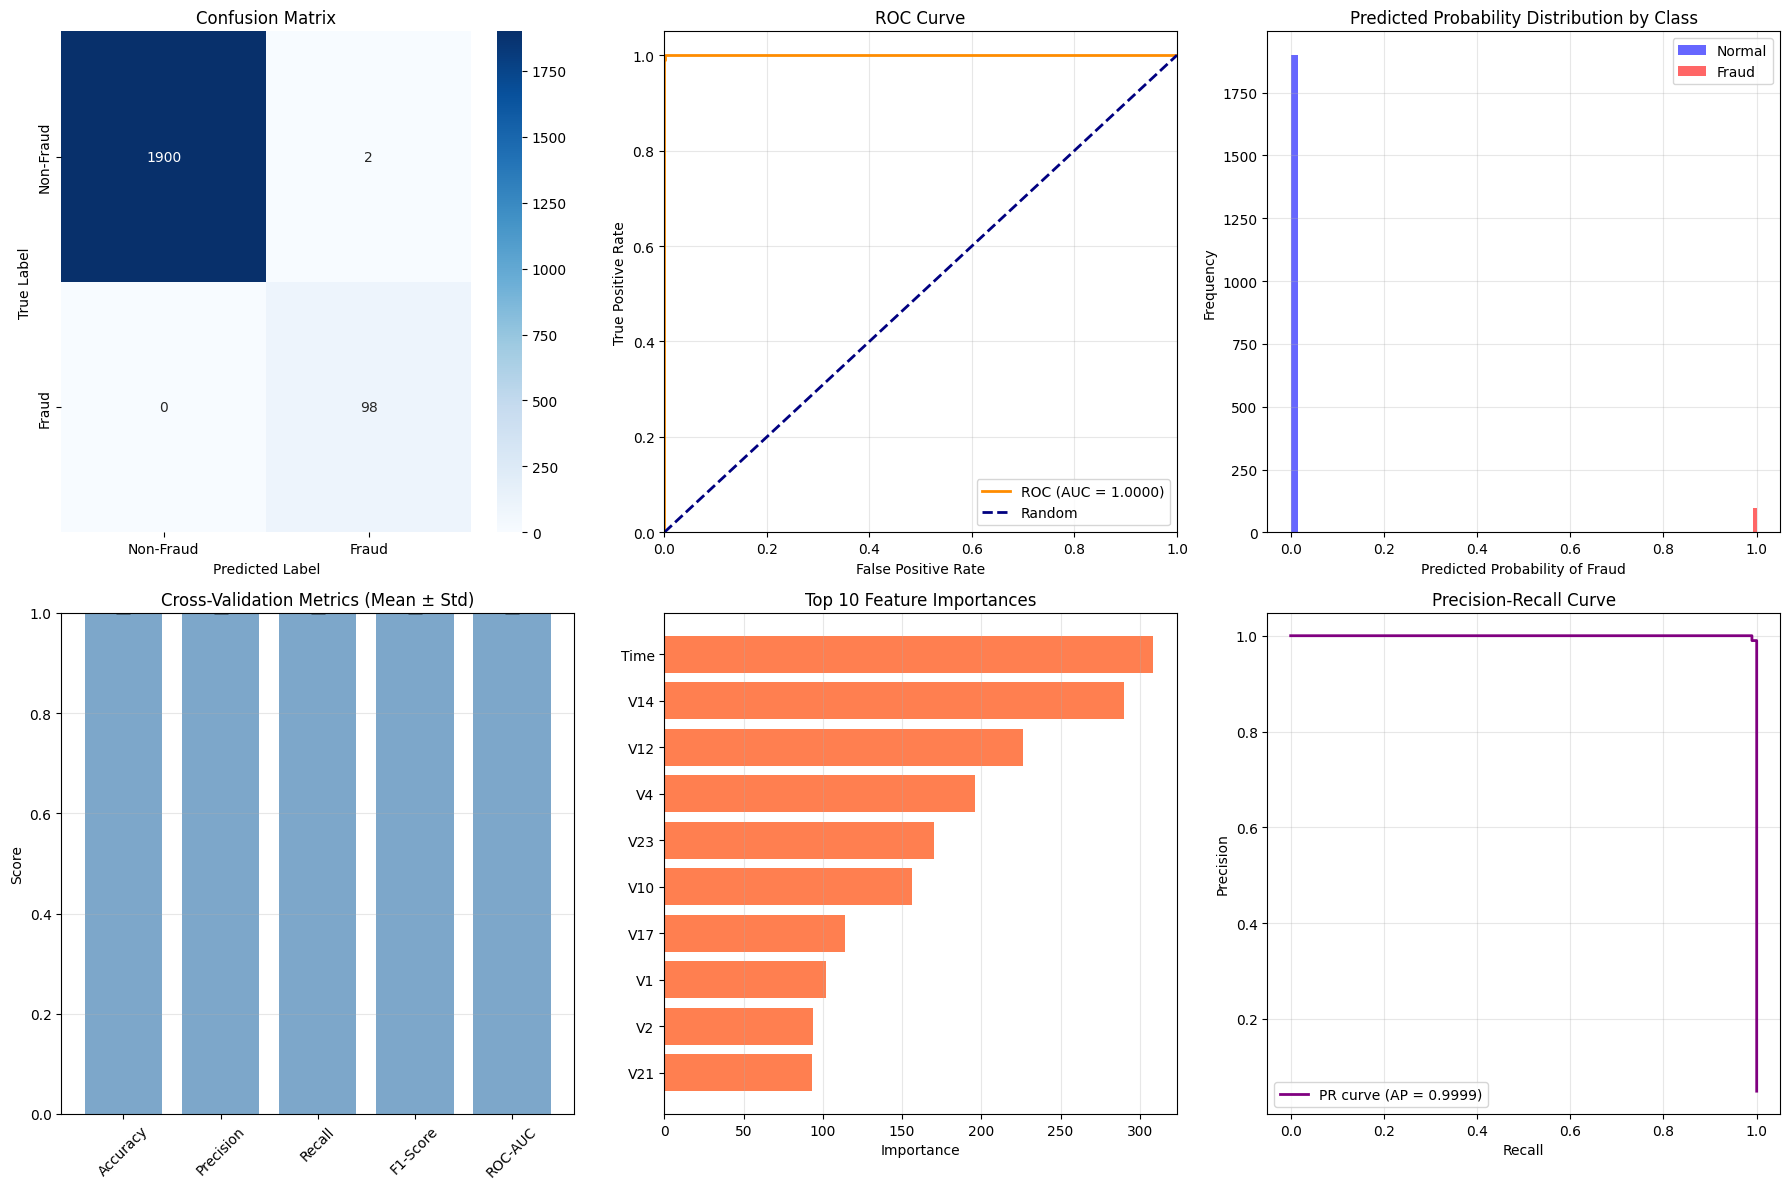


LightGBM evaluation complete with statistical analysis!


In [ ]:
import lightgbm as lgb
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def calculate_confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for a dataset"""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - ci, mean + ci

def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

# Train LightGBM (supervised - uses SMOTE-balanced data)
print("Training LightGBM with statistical analysis...")

lgbm_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Fit on SMOTE-balanced training data
lgbm_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]  # Probability of fraud

print("\n" + "="*70)
print("LIGHTGBM RESULTS WITH STATISTICAL ANALYSIS")
print("="*70)

# ========== BASIC METRICS ==========
print("\n--- Basic Performance Metrics ---")
accuracy = accuracy_score(y_test, y_pred_lgbm)
precision = precision_score(y_test, y_pred_lgbm, zero_division=0)
recall = recall_score(y_test, y_pred_lgbm, zero_division=0)
f1 = f1_score(y_test, y_pred_lgbm, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_lgbm)
mcc = matthews_corrcoef(y_test, y_pred_lgbm)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"MCC:       {mcc:.4f}")

# ========== CROSS-VALIDATION WITH CONFIDENCE INTERVALS ==========
print("\n--- Cross-Validation Analysis (5-Fold) ---")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_auc = []

for train_idx, val_idx in skf.split(X_train_smote, y_train_smote):
    X_cv_train = X_train_smote.iloc[train_idx] if hasattr(X_train_smote, 'iloc') else X_train_smote[train_idx]
    X_cv_val = X_train_smote.iloc[val_idx] if hasattr(X_train_smote, 'iloc') else X_train_smote[val_idx]
    y_cv_train = y_train_smote.iloc[train_idx] if hasattr(y_train_smote, 'iloc') else y_train_smote[train_idx]
    y_cv_val = y_train_smote.iloc[val_idx] if hasattr(y_train_smote, 'iloc') else y_train_smote[val_idx]

    # Train model
    lgbm_cv = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
    lgbm_cv.fit(X_cv_train, y_cv_train)

    # Predict
    y_pred_cv = lgbm_cv.predict(X_cv_val)
    y_proba_cv = lgbm_cv.predict_proba(X_cv_val)[:, 1]

    # Calculate metrics
    cv_scores.append(accuracy_score(y_cv_val, y_pred_cv))
    cv_precision.append(precision_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_recall.append(recall_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_f1.append(f1_score(y_cv_val, y_pred_cv, zero_division=0))
    cv_auc.append(roc_auc_score(y_cv_val, y_proba_cv))

# Calculate confidence intervals
metrics = {
    'Accuracy': cv_scores,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1,
    'ROC-AUC': cv_auc
}

for metric_name, values in metrics.items():
    mean, lower, upper = calculate_confidence_interval(values)
    std = np.std(values)
    print(f"{metric_name}: {mean:.4f} ± {std:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")

# ========== STATISTICAL SIGNIFICANCE TESTS ==========
print("\n--- Statistical Significance Tests ---")

# Separate probabilities by true class
fraud_proba = y_proba_lgbm[y_test == 1]
normal_proba = y_proba_lgbm[y_test == 0]

# t-test: Are fraud and normal probabilities significantly different?
t_stat, p_value = stats.ttest_ind(fraud_proba, normal_proba)
print(f"T-test (Fraud vs Normal predicted probabilities):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Cohen's d: Effect size
cohens_d = calculate_cohens_d(fraud_proba, normal_proba)
print(f"\nCohen's d (Effect Size): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect = "negligible"
elif abs(cohens_d) < 0.5:
    effect = "small"
elif abs(cohens_d) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"  Interpretation: {effect} effect")

# ========== CONFUSION MATRIX ==========
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_lgbm)
print(cm)
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# ========== FEATURE IMPORTANCE ==========
print("\n--- Top 10 Most Important Features ---")
feature_importance = lgbm_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(10)
print(importance_df.to_string(index=False))

# ========== VISUALIZATIONS ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgbm)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(alpha=0.3)

# 3. Probability Distribution
axes[0,2].hist(normal_proba, bins=50, alpha=0.6, label='Normal', color='blue')
axes[0,2].hist(fraud_proba, bins=50, alpha=0.6, label='Fraud', color='red')
axes[0,2].set_xlabel('Predicted Probability of Fraud')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Predicted Probability Distribution by Class')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Cross-Validation Metrics with Error Bars
metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]
axes[1,0].bar(metric_names, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Cross-Validation Metrics (Mean ± Std)')
axes[1,0].set_ylim([0, 1])
axes[1,0].grid(alpha=0.3, axis='y')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Feature Importance (Top 10)
top_features = importance_df.head(10)
axes[1,1].barh(top_features['Feature'], top_features['Importance'], color='coral')
axes[1,1].set_xlabel('Importance')
axes[1,1].set_title('Top 10 Feature Importances')
axes[1,1].invert_yaxis()
axes[1,1].grid(alpha=0.3, axis='x')

# 6. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_lgbm)
avg_precision = average_precision_score(y_test, y_proba_lgbm)
axes[1,2].plot(recall_curve, precision_curve, color='purple', lw=2,
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[1,2].set_xlabel('Recall')
axes[1,2].set_ylabel('Precision')
axes[1,2].set_title('Precision-Recall Curve')
axes[1,2].legend(loc="lower left")
axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("LightGBM evaluation complete with statistical analysis!")
print("="*70)

Wow. LightGBM is an insanely powerful model. It did almost perfectly. Isolation Forests may be beat. However, let's do an abalation study on whether or not the SMOTE made it as powerful as it is. We will do a comparison between both without SMOTE.

In [ ]:
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef)
import pandas as pd
import numpy as np

print("="*70)
print("MODELS WITHOUT SMOTE - QUICK COMPARISON")
print("="*70)

# ========== ISOLATION FOREST (NO SMOTE) ==========
print("\n--- Training Isolation Forest (no SMOTE needed - unsupervised) ---")
iso_forest_no_smote = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

iso_forest_no_smote.fit(X_train)
y_pred_iso_no_smote = (iso_forest_no_smote.predict(X_test) == -1).astype(int)
y_scores_iso_no_smote = -iso_forest_no_smote.decision_function(X_test)

# Metrics
iso_no_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_iso_no_smote),
    'Precision': precision_score(y_test, y_pred_iso_no_smote, zero_division=0),
    'Recall': recall_score(y_test, y_pred_iso_no_smote, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_iso_no_smote, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_scores_iso_no_smote),
    'MCC': matthews_corrcoef(y_test, y_pred_iso_no_smote)
}

print("Isolation Forest (No SMOTE) Results:")
for metric, value in iso_no_smote_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== LIGHTGBM WITHOUT SMOTE ==========
print("\n--- Training LightGBM WITHOUT SMOTE (using class weights) ---")

# Calculate class weights for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

lgbm_no_smote = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance with weights
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_no_smote.fit(X_train, y_train)
y_pred_lgbm_no_smote = lgbm_no_smote.predict(X_test)
y_proba_lgbm_no_smote = lgbm_no_smote.predict_proba(X_test)[:, 1]

# Metrics
lgbm_no_smote_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_lgbm_no_smote),
    'Precision': precision_score(y_test, y_pred_lgbm_no_smote, zero_division=0),
    'Recall': recall_score(y_test, y_pred_lgbm_no_smote, zero_division=0),
    'F1-Score': f1_score(y_test, y_pred_lgbm_no_smote, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lgbm_no_smote),
    'MCC': matthews_corrcoef(y_test, y_pred_lgbm_no_smote)
}

print("LightGBM (No SMOTE, Class Weights) Results:")
for metric, value in lgbm_no_smote_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== COMPARISON TABLE ==========
print("\n" + "="*70)
print("SIDE-BY-SIDE COMPARISON (WITHOUT SMOTE)")
print("="*70)

comparison_df = pd.DataFrame({
    'Isolation Forest': iso_no_smote_metrics,
    'LightGBM (Class Weights)': lgbm_no_smote_metrics
})

print(comparison_df.to_string())

# ========== PERFORMANCE DIFFERENCES ==========
print("\n--- Performance Differences (LightGBM - Isolation Forest) ---")
for metric in iso_no_smote_metrics.keys():
    diff = lgbm_no_smote_metrics[metric] - iso_no_smote_metrics[metric]
    print(f"{metric}: {diff:+.4f}")

print("\n" + "="*70)
print("Note: This comparison uses original imbalanced data")
print("- Isolation Forest: Naturally handles imbalance (unsupervised)")
print("- LightGBM: Uses scale_pos_weight parameter for class imbalance")
print("="*70)

MODELS WITHOUT SMOTE - QUICK COMPARISON

--- Training Isolation Forest (no SMOTE needed - unsupervised) ---
Isolation Forest (No SMOTE) Results:
  Accuracy: 0.9655
  Precision: 0.6465
  Recall: 0.6531
  F1-Score: 0.6497
  ROC-AUC: 0.9652
  MCC: 0.6316

--- Training LightGBM WITHOUT SMOTE (using class weights) ---
Scale pos weight: 19.30
LightGBM (No SMOTE, Class Weights) Results:
  Accuracy: 0.9990
  Precision: 1.0000
  Recall: 0.9796
  F1-Score: 0.9897
  ROC-AUC: 0.9999
  MCC: 0.9892

SIDE-BY-SIDE COMPARISON (WITHOUT SMOTE)
           Isolation Forest  LightGBM (Class Weights)
Accuracy           0.965500                  0.999000
Precision          0.646465                  1.000000
Recall             0.653061                  0.979592
F1-Score           0.649746                  0.989691
ROC-AUC            0.965176                  0.999938
MCC                0.631612                  0.989223

--- Performance Differences (LightGBM - Isolation Forest) ---
Accuracy: +0.0335
Precision:

LightGBM still performed almost perfectly, dominating Isolation Forests, even without SMOTE run before. Perhaps it was the dataset that allowed LightGBM to perform so well. Let's grab another dataset and try again. This time, instead of using SMOTE, let's just pick 10,000 of each class.

In [ ]:
# Download the second dataset
!kaggle datasets download -d dhanushnarayananr/credit-card-fraud

# Unzip the dataset
!unzip -q credit-card-fraud.zip

# Load and view the data
import pandas as pd

df2 = pd.read_csv('card_transdata.csv')
print(f"Original dataset shape: {df2.shape}")

# Identify the class column (usually 'fraud' or 'Class')
class_column = 'fraud' if 'fraud' in df2.columns else 'Class'
print(f"\nClass column: {class_column}")
print(f"Original class distribution:")
print(df2[class_column].value_counts())

# Separate fraud and non-fraud cases
fraud_cases = df2[df2[class_column] == 1]
non_fraud_cases = df2[df2[class_column] == 0]

print(f"\nTotal fraud cases: {len(fraud_cases)}")
print(f"Total non-fraud cases: {len(non_fraud_cases)}")

# Take 10,000 of each class
fraud_sample = fraud_cases.sample(n=min(10000, len(fraud_cases)), random_state=42)
non_fraud_sample = non_fraud_cases.sample(n=min(10000, len(non_fraud_cases)), random_state=42)

# Combine and shuffle
df2 = pd.concat([fraud_sample, non_fraud_sample], ignore_index=True)
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset shape: {df2.shape}")
print(f"Fraud cases: {df2[class_column].sum()}")
print(f"Non-fraud cases: {(df2[class_column] == 0).sum()}")
print(f"Fraud percentage: {df2[class_column].sum() / len(df2) * 100:.2f}%")

print(f"\nFirst 5 rows:")
print(df2.head())
print(f"\nColumn names:")
print(df2.columns.tolist())

Dataset URL: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud
License(s): CC0-1.0
credit-card-fraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace card_transdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Original dataset shape: (1000000, 8)

Class column: fraud
Original class distribution:
fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

Total fraud cases: 87403
Total non-fraud cases: 912597

Balanced dataset shape: (20000, 8)
Fraud cases: 10000.0
Non-fraud cases: 10000
Fraud percentage: 50.00%

First 5 rows:
   distance_from_home  distance_from_last_transaction  \
0            5.702163                        2.578562   
1           65.825761                        2.402898   
2           10.508485                        0.376838   
3            8.078307                        1.583819   
4            3.055901                        4.409463   

   ratio_to_median_purchase_price  repeat_retailer  used_chip 

Let's check for missing values, do some feature scaling so that features have equal power over the outcome, and get this dataset into a train-test split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*70)
print("PREPROCESSING DATASET 2")
print("="*70)

# Check for missing values
print("\nMissing values:")
print(df2.isnull().sum())

# Check class distribution (should be 50-50)
print(f"\nClass distribution:")
print(df2['fraud'].value_counts())
print(f"Fraud percentage: {df2['fraud'].sum() / len(df2) * 100:.2f}%")

# Separate features and target
X2 = df2.drop('fraud', axis=1)
y2 = df2['fraud'].astype(int)  # Convert to integer

print(f"\nFeatures shape: {X2.shape}")
print(f"Target shape: {y2.shape}")

# Split the data (80-20 split, stratified)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

print(f"\nTraining set size: {X2_train.shape}")
print(f"Test set size: {X2_test.shape}")
print(f"Fraud cases in train: {y2_train.sum()}")
print(f"Fraud cases in test: {y2_test.sum()}")

# Scale features (important for this dataset since features are on different scales)
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

# Convert back to DataFrame for easier handling
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=X2_train.columns)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=X2_test.columns)

print("\n--- Feature Statistics (After Scaling) ---")
print("Training set mean (should be ~0):")
print(X2_train_scaled.mean())
print("\nTraining set std (should be ~1):")
print(X2_train_scaled.std())

print("\n" + "="*70)
print("Dataset 2 preprocessing complete!")
print("="*70)
print("\nNOTE: This dataset is already balanced (50% fraud)")
print("SMOTE is NOT needed - you can train models directly on this data")
print("\nUse X2_train_scaled, y2_train for training")
print("Use X2_test_scaled, y2_test for testing")
print("="*70)

PREPROCESSING DATASET 2

Missing values:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Class distribution:
fraud
0.0    10000
1.0    10000
Name: count, dtype: int64
Fraud percentage: 50.00%

Features shape: (20000, 7)
Target shape: (20000,)

Training set size: (16000, 7)
Test set size: (4000, 7)
Fraud cases in train: 8000
Fraud cases in test: 2000

--- Feature Statistics (After Scaling) ---
Training set mean (should be ~0):
distance_from_home                3.108624e-17
distance_from_last_transaction   -2.220446e-17
ratio_to_median_purchase_price   -2.131628e-17
repeat_retailer                  -4.707346e-17
used_chip                         4.396483e-17
used_pin_number                   9.858780e-17
online_order                     -

And finally, let's compare Isolation Forests to LightGBM.

In [ ]:
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef)
import pandas as pd
import numpy as np

print("="*70)
print("DATASET 2 - ISOLATION FOREST vs LIGHTGBM COMPARISON")
print("="*70)
print("Note: Dataset 2 is balanced (50% fraud), so no SMOTE needed")
print("="*70)

# ========== ISOLATION FOREST ==========
print("\n--- Training Isolation Forest ---")
iso_forest_d2 = IsolationForest(
    n_estimators=100,
    contamination=0.5,  # 50% fraud rate in this dataset
    random_state=42,
    n_jobs=-1
)

iso_forest_d2.fit(X2_train_scaled)
y_pred_iso_d2 = (iso_forest_d2.predict(X2_test_scaled) == -1).astype(int)
y_scores_iso_d2 = -iso_forest_d2.decision_function(X2_test_scaled)

# Metrics
iso_d2_metrics = {
    'Accuracy': accuracy_score(y2_test, y_pred_iso_d2),
    'Precision': precision_score(y2_test, y_pred_iso_d2, zero_division=0),
    'Recall': recall_score(y2_test, y_pred_iso_d2, zero_division=0),
    'F1-Score': f1_score(y2_test, y_pred_iso_d2, zero_division=0),
    'ROC-AUC': roc_auc_score(y2_test, y_scores_iso_d2),
    'MCC': matthews_corrcoef(y2_test, y_pred_iso_d2)
}

print("Isolation Forest Results:")
for metric, value in iso_d2_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== LIGHTGBM ==========
print("\n--- Training LightGBM (no class weights needed - balanced data) ---")

lgbm_d2 = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_d2.fit(X2_train_scaled, y2_train)
y_pred_lgbm_d2 = lgbm_d2.predict(X2_test_scaled)
y_proba_lgbm_d2 = lgbm_d2.predict_proba(X2_test_scaled)[:, 1]

# Metrics
lgbm_d2_metrics = {
    'Accuracy': accuracy_score(y2_test, y_pred_lgbm_d2),
    'Precision': precision_score(y2_test, y_pred_lgbm_d2, zero_division=0),
    'Recall': recall_score(y2_test, y_pred_lgbm_d2, zero_division=0),
    'F1-Score': f1_score(y2_test, y_pred_lgbm_d2, zero_division=0),
    'ROC-AUC': roc_auc_score(y2_test, y_proba_lgbm_d2),
    'MCC': matthews_corrcoef(y2_test, y_pred_lgbm_d2)
}

print("LightGBM Results:")
for metric, value in lgbm_d2_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== COMPARISON TABLE ==========
print("\n" + "="*70)
print("SIDE-BY-SIDE COMPARISON - DATASET 2")
print("="*70)

comparison_df = pd.DataFrame({
    'Isolation Forest': iso_d2_metrics,
    'LightGBM': lgbm_d2_metrics
})

print(comparison_df.to_string())

# ========== PERFORMANCE DIFFERENCES ==========
print("\n--- Performance Differences (LightGBM - Isolation Forest) ---")
for metric in iso_d2_metrics.keys():
    diff = lgbm_d2_metrics[metric] - iso_d2_metrics[metric]
    print(f"{metric}: {diff:+.4f}")

# ========== FEATURE IMPORTANCE (LightGBM) ==========
print("\n--- Feature Importance (LightGBM) ---")
feature_importance = lgbm_d2.feature_importances_
feature_names = X2_train_scaled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print("\n" + "="*70)
print("DATASET 2 COMPARISON COMPLETE")
print("="*70)
print("\nKey Observations:")
print("- Dataset 2 has only 7 features vs Dataset 1's 29 features")
print("- Dataset 2 is balanced (50% fraud) vs Dataset 1's imbalanced (4.92% fraud)")
print("- No SMOTE was used since data is already balanced")
print("="*70)

DATASET 2 - ISOLATION FOREST vs LIGHTGBM COMPARISON
Note: Dataset 2 is balanced (50% fraud), so no SMOTE needed

--- Training Isolation Forest ---
Isolation Forest Results:
  Accuracy: 0.4452
  Precision: 0.4454
  Recall: 0.4465
  F1-Score: 0.4459
  ROC-AUC: 0.4849
  MCC: -0.1095

--- Training LightGBM (no class weights needed - balanced data) ---
LightGBM Results:
  Accuracy: 0.9980
  Precision: 0.9965
  Recall: 0.9995
  F1-Score: 0.9980
  ROC-AUC: 1.0000
  MCC: 0.9960

SIDE-BY-SIDE COMPARISON - DATASET 2
           Isolation Forest  LightGBM
Accuracy           0.445250  0.998000
Precision          0.445387  0.996510
Recall             0.446500  0.999500
F1-Score           0.445943  0.998003
ROC-AUC            0.484863  0.999982
MCC               -0.109500  0.996004

--- Performance Differences (LightGBM - Isolation Forest) ---
Accuracy: +0.5528
Precision: +0.5511
Recall: +0.5530
F1-Score: +0.5521
ROC-AUC: +0.5151
MCC: +1.1055

--- Feature Importance (LightGBM) ---
                   

Once again, LightGBM did near-perfectly. Isolation Forests did not even do half as well this time. Let's try one more dataset. We will grab a dataset of European cardholders in the year 2023, and we will once again take 10,000 of each class.

In [ ]:
# Download the third dataset
!kaggle datasets download -d nelgiriyewithana/credit-card-fraud-detection-dataset-2023

# Unzip the dataset
!unzip -q credit-card-fraud-detection-dataset-2023.zip

# Load and view the data
import pandas as pd

df3 = pd.read_csv('creditcard_2023.csv')
print(f"Original dataset shape: {df3.shape}")

# Identify the class column
class_column = 'Class' if 'Class' in df3.columns else 'fraud'
print(f"\nClass column: {class_column}")
print(f"Original class distribution:")
print(df3[class_column].value_counts())

# Separate fraud and non-fraud cases
fraud_cases = df3[df3[class_column] == 1]
non_fraud_cases = df3[df3[class_column] == 0]

print(f"\nTotal fraud cases: {len(fraud_cases)}")
print(f"Total non-fraud cases: {len(non_fraud_cases)}")

# Take 10,000 of each class
fraud_sample = fraud_cases.sample(n=min(10000, len(fraud_cases)), random_state=42)
non_fraud_sample = non_fraud_cases.sample(n=min(10000, len(non_fraud_cases)), random_state=42)

# Combine and shuffle
df3 = pd.concat([fraud_sample, non_fraud_sample], ignore_index=True)
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset shape: {df3.shape}")
print(f"Fraud cases: {df3[class_column].sum()}")
print(f"Non-fraud cases: {(df3[class_column] == 0).sum()}")
print(f"Fraud percentage: {df3[class_column].sum() / len(df3) * 100:.2f}%")

print(f"\nFirst 5 rows:")
print(df3.head())
print(f"\nColumn names:")
print(df3.columns.tolist())

Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
License(s): other
 85% 121M/143M [00:00<00:00, 1.21GB/s]
100% 143M/143M [00:00<00:00, 701MB/s] 
Original dataset shape: (568630, 31)

Class column: Class
Original class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64

Total fraud cases: 284315
Total non-fraud cases: 284315

Balanced dataset shape: (20000, 31)
Fraud cases: 10000
Non-fraud cases: 10000
Fraud percentage: 50.00%

First 5 rows:
       id        V1        V2        V3        V4        V5        V6  \
0   87544  1.131726 -0.549194  0.444811 -0.914261  0.032435 -0.182955   
1  451530  0.183593  0.312170 -0.656037  1.041418  0.008825 -0.016019   
2  529595 -1.051311  0.586470 -0.812755  0.069662 -0.439129 -0.742375   
3  427074 -2.138458  2.477343 -2.097651  1.196020 -2.514557 -2.451085   
4   39618 -0.142121  0.117285  1.066365  0.157867  1.073633  0.783221   

         V7        V8        V9  ...       

Let's do some preprocessing, scale these features and let's get to testing it.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*70)
print("PREPROCESSING DATASET 3")
print("="*70)

# Identify class column
class_column = 'Class' if 'Class' in df3.columns else 'fraud'

# Check for missing values
print("\nMissing values:")
print(df3.isnull().sum().sum())

# Check class distribution
print(f"\nClass distribution:")
print(df3[class_column].value_counts())
print(f"Fraud percentage: {df3[class_column].sum() / len(df3) * 100:.2f}%")

# Separate features and target
X3 = df3.drop(class_column, axis=1)
y3 = df3[class_column].astype(int)

print(f"\nFeatures shape: {X3.shape}")
print(f"Target shape: {y3.shape}")
print(f"\nFeature names:")
print(X3.columns.tolist())

# Split the data (80-20 split, stratified)
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42, stratify=y3
)

print(f"\nTraining set size: {X3_train.shape}")
print(f"Test set size: {X3_test.shape}")
print(f"Fraud cases in train: {y3_train.sum()}")
print(f"Fraud cases in test: {y3_test.sum()}")

# Scale features
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_test_scaled = scaler3.transform(X3_test)

# Convert back to DataFrame
X3_train_scaled = pd.DataFrame(X3_train_scaled, columns=X3_train.columns)
X3_test_scaled = pd.DataFrame(X3_test_scaled, columns=X3_test.columns)

print("\n" + "="*70)
print("Dataset 3 preprocessing complete!")
print("="*70)
print("\nNOTE: This dataset is balanced (50% fraud)")
print("SMOTE is NOT needed")
print("\nUse X3_train_scaled, y3_train for training")
print("Use X3_test_scaled, y3_test for testing")
print("="*70)

PREPROCESSING DATASET 3

Missing values:
0

Class distribution:
Class
0    10000
1    10000
Name: count, dtype: int64
Fraud percentage: 50.00%

Features shape: (20000, 30)
Target shape: (20000,)

Feature names:
['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Training set size: (16000, 30)
Test set size: (4000, 30)
Fraud cases in train: 8000
Fraud cases in test: 2000

Dataset 3 preprocessing complete!

NOTE: This dataset is balanced (50% fraud)
SMOTE is NOT needed

Use X3_train_scaled, y3_train for training
Use X3_test_scaled, y3_test for testing


Time for the comparison!

In [ ]:
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef)
import pandas as pd
import numpy as np

print("="*70)
print("DATASET 3 - ISOLATION FOREST vs LIGHTGBM COMPARISON")
print("="*70)
print("Note: Dataset 3 is balanced (50% fraud), so no SMOTE needed")
print("="*70)

# ========== ISOLATION FOREST ==========
print("\n--- Training Isolation Forest ---")
iso_forest_d3 = IsolationForest(
    n_estimators=100,
    contamination=0.5,  # 50% fraud rate in this dataset
    random_state=42,
    n_jobs=-1
)

iso_forest_d3.fit(X3_train_scaled)
y_pred_iso_d3 = (iso_forest_d3.predict(X3_test_scaled) == -1).astype(int)
y_scores_iso_d3 = -iso_forest_d3.decision_function(X3_test_scaled)

# Metrics
iso_d3_metrics = {
    'Accuracy': accuracy_score(y3_test, y_pred_iso_d3),
    'Precision': precision_score(y3_test, y_pred_iso_d3, zero_division=0),
    'Recall': recall_score(y3_test, y_pred_iso_d3, zero_division=0),
    'F1-Score': f1_score(y3_test, y_pred_iso_d3, zero_division=0),
    'ROC-AUC': roc_auc_score(y3_test, y_scores_iso_d3),
    'MCC': matthews_corrcoef(y3_test, y_pred_iso_d3)
}

print("Isolation Forest Results:")
for metric, value in iso_d3_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== LIGHTGBM ==========
print("\n--- Training LightGBM (no class weights needed - balanced data) ---")

lgbm_d3 = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_d3.fit(X3_train_scaled, y3_train)
y_pred_lgbm_d3 = lgbm_d3.predict(X3_test_scaled)
y_proba_lgbm_d3 = lgbm_d3.predict_proba(X3_test_scaled)[:, 1]

# Metrics
lgbm_d3_metrics = {
    'Accuracy': accuracy_score(y3_test, y_pred_lgbm_d3),
    'Precision': precision_score(y3_test, y_pred_lgbm_d3, zero_division=0),
    'Recall': recall_score(y3_test, y_pred_lgbm_d3, zero_division=0),
    'F1-Score': f1_score(y3_test, y_pred_lgbm_d3, zero_division=0),
    'ROC-AUC': roc_auc_score(y3_test, y_proba_lgbm_d3),
    'MCC': matthews_corrcoef(y3_test, y_pred_lgbm_d3)
}

print("LightGBM Results:")
for metric, value in lgbm_d3_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== COMPARISON TABLE ==========
print("\n" + "="*70)
print("SIDE-BY-SIDE COMPARISON - DATASET 3")
print("="*70)

comparison_df = pd.DataFrame({
    'Isolation Forest': iso_d3_metrics,
    'LightGBM': lgbm_d3_metrics
})

print(comparison_df.to_string())

# ========== PERFORMANCE DIFFERENCES ==========
print("\n--- Performance Differences (LightGBM - Isolation Forest) ---")
for metric in iso_d3_metrics.keys():
    diff = lgbm_d3_metrics[metric] - iso_d3_metrics[metric]
    print(f"{metric}: {diff:+.4f}")

# ========== FEATURE IMPORTANCE (LightGBM) ==========
print("\n--- Top 10 Most Important Features (LightGBM) ---")
feature_importance = lgbm_d3.feature_importances_
feature_names = X3_train_scaled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(10)
print(importance_df.to_string(index=False))

print("\n" + "="*70)
print("DATASET 3 COMPARISON COMPLETE")
print("="*70)

DATASET 3 - ISOLATION FOREST vs LIGHTGBM COMPARISON
Note: Dataset 3 is balanced (50% fraud), so no SMOTE needed

--- Training Isolation Forest ---
Isolation Forest Results:
  Accuracy: 0.5913
  Precision: 0.5928
  Recall: 0.5830
  F1-Score: 0.5878
  ROC-AUC: 0.6467
  MCC: 0.1825

--- Training LightGBM (no class weights needed - balanced data) ---
LightGBM Results:
  Accuracy: 0.9995
  Precision: 0.9995
  Recall: 0.9995
  F1-Score: 0.9995
  ROC-AUC: 1.0000
  MCC: 0.9990

SIDE-BY-SIDE COMPARISON - DATASET 3
           Isolation Forest  LightGBM
Accuracy           0.591250  0.999500
Precision          0.592781  0.999500
Recall             0.583000  0.999500
F1-Score           0.587850  0.999500
ROC-AUC            0.646721  0.999999
MCC                0.182525  0.999000

--- Performance Differences (LightGBM - Isolation Forest) ---
Accuracy: +0.4083
Precision: +0.4067
Recall: +0.4165
F1-Score: +0.4117
ROC-AUC: +0.3533
MCC: +0.8165

--- Top 10 Most Important Features (LightGBM) ---
Feature 

 LightGBM overwhelmingly outperformed Isolation Forests. Isolation Forests seem to be performing poorly. Upon investigation, it is likely that our preprocessed datasets are not making the fraud class "rare" enough to be detected as anomalies. We tried a class imbalance with the first dataset, but let's try Isolation Forests again with the last 2 datasets with a ratio of 10:1.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef)

print("="*70)
print("RESAMPLING DATASETS 2 & 3 FOR IMBALANCED ISOLATION FOREST TEST")
print("="*70)

# ========== DATASET 2 - RESAMPLE TO 18K LEGIT, 2K FRAUD ==========
print("\n--- Resampling Dataset 2 ---")

# Reload original dataset 2
df2_reload = pd.read_csv('card_transdata.csv')
fraud_d2 = df2_reload[df2_reload['fraud'] == 1]
legit_d2 = df2_reload[df2_reload['fraud'] == 0]

# Sample 2,000 fraud and 18,000 legit
fraud_sample_d2 = fraud_d2.sample(n=min(2000, len(fraud_d2)), random_state=42)
legit_sample_d2 = legit_d2.sample(n=18000, random_state=42)

# Combine and shuffle
df2_imbalanced = pd.concat([fraud_sample_d2, legit_sample_d2], ignore_index=True)
df2_imbalanced = df2_imbalanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset 2 - New shape: {df2_imbalanced.shape}")
print(f"Fraud cases: {df2_imbalanced['fraud'].sum()}")
print(f"Legit cases: {(df2_imbalanced['fraud'] == 0).sum()}")
print(f"Fraud percentage: {df2_imbalanced['fraud'].sum() / len(df2_imbalanced) * 100:.2f}%")

# Preprocess Dataset 2
X2_imb = df2_imbalanced.drop('fraud', axis=1)
y2_imb = df2_imbalanced['fraud'].astype(int)

X2_imb_train, X2_imb_test, y2_imb_train, y2_imb_test = train_test_split(
    X2_imb, y2_imb, test_size=0.2, random_state=42, stratify=y2_imb
)

scaler2_imb = StandardScaler()
X2_imb_train_scaled = pd.DataFrame(
    scaler2_imb.fit_transform(X2_imb_train),
    columns=X2_imb_train.columns
)
X2_imb_test_scaled = pd.DataFrame(
    scaler2_imb.transform(X2_imb_test),
    columns=X2_imb_test.columns
)

# ========== DATASET 3 - RESAMPLE TO 18K LEGIT, 2K FRAUD ==========
print("\n--- Resampling Dataset 3 ---")

# Reload original dataset 3
df3_reload = pd.read_csv('creditcard_2023.csv')
class_col = 'Class' if 'Class' in df3_reload.columns else 'fraud'
fraud_d3 = df3_reload[df3_reload[class_col] == 1]
legit_d3 = df3_reload[df3_reload[class_col] == 0]

# Sample 2,000 fraud and 18,000 legit
fraud_sample_d3 = fraud_d3.sample(n=min(2000, len(fraud_d3)), random_state=42)
legit_sample_d3 = legit_d3.sample(n=18000, random_state=42)

# Combine and shuffle
df3_imbalanced = pd.concat([fraud_sample_d3, legit_sample_d3], ignore_index=True)
df3_imbalanced = df3_imbalanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset 3 - New shape: {df3_imbalanced.shape}")
print(f"Fraud cases: {df3_imbalanced[class_col].sum()}")
print(f"Legit cases: {(df3_imbalanced[class_col] == 0).sum()}")
print(f"Fraud percentage: {df3_imbalanced[class_col].sum() / len(df3_imbalanced) * 100:.2f}%")

# Preprocess Dataset 3
X3_imb = df3_imbalanced.drop(class_col, axis=1)
y3_imb = df3_imbalanced[class_col].astype(int)

X3_imb_train, X3_imb_test, y3_imb_train, y3_imb_test = train_test_split(
    X3_imb, y3_imb, test_size=0.2, random_state=42, stratify=y3_imb
)

scaler3_imb = StandardScaler()
X3_imb_train_scaled = pd.DataFrame(
    scaler3_imb.fit_transform(X3_imb_train),
    columns=X3_imb_train.columns
)
X3_imb_test_scaled = pd.DataFrame(
    scaler3_imb.transform(X3_imb_test),
    columns=X3_imb_test.columns
)

print("\n" + "="*70)
print("ISOLATION FOREST ON IMBALANCED DATA")
print("="*70)

# ========== DATASET 2 - ISOLATION FOREST ==========
print("\n--- Dataset 2: Isolation Forest (10% fraud) ---")
iso_d2_imb = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # 10% fraud
    random_state=42,
    n_jobs=-1
)

iso_d2_imb.fit(X2_imb_train_scaled)
y_pred_iso_d2_imb = (iso_d2_imb.predict(X2_imb_test_scaled) == -1).astype(int)
y_scores_iso_d2_imb = -iso_d2_imb.decision_function(X2_imb_test_scaled)

iso_d2_imb_metrics = {
    'Accuracy': accuracy_score(y2_imb_test, y_pred_iso_d2_imb),
    'Precision': precision_score(y2_imb_test, y_pred_iso_d2_imb, zero_division=0),
    'Recall': recall_score(y2_imb_test, y_pred_iso_d2_imb, zero_division=0),
    'F1-Score': f1_score(y2_imb_test, y_pred_iso_d2_imb, zero_division=0),
    'ROC-AUC': roc_auc_score(y2_imb_test, y_scores_iso_d2_imb),
    'MCC': matthews_corrcoef(y2_imb_test, y_pred_iso_d2_imb)
}

print("Results:")
for metric, value in iso_d2_imb_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== DATASET 3 - ISOLATION FOREST ==========
print("\n--- Dataset 3: Isolation Forest (10% fraud) ---")
iso_d3_imb = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # 10% fraud
    random_state=42,
    n_jobs=-1
)

iso_d3_imb.fit(X3_imb_train_scaled)
y_pred_iso_d3_imb = (iso_d3_imb.predict(X3_imb_test_scaled) == -1).astype(int)
y_scores_iso_d3_imb = -iso_d3_imb.decision_function(X3_imb_test_scaled)

iso_d3_imb_metrics = {
    'Accuracy': accuracy_score(y3_imb_test, y_pred_iso_d3_imb),
    'Precision': precision_score(y3_imb_test, y_pred_iso_d3_imb, zero_division=0),
    'Recall': recall_score(y3_imb_test, y_pred_iso_d3_imb, zero_division=0),
    'F1-Score': f1_score(y3_imb_test, y_pred_iso_d3_imb, zero_division=0),
    'ROC-AUC': roc_auc_score(y3_imb_test, y_scores_iso_d3_imb),
    'MCC': matthews_corrcoef(y3_imb_test, y_pred_iso_d3_imb)
}

print("Results:")
for metric, value in iso_d3_imb_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ========== COMPARISON TABLE ==========
print("\n" + "="*70)
print("ISOLATION FOREST: BALANCED vs IMBALANCED COMPARISON")
print("="*70)

comparison_table = pd.DataFrame({
    'Dataset 2 (50% fraud)': iso_d2_metrics if 'iso_d2_metrics' in dir() else {k: 0 for k in iso_d2_imb_metrics.keys()},
    'Dataset 2 (10% fraud)': iso_d2_imb_metrics,
    'Dataset 3 (50% fraud)': iso_d3_metrics if 'iso_d3_metrics' in dir() else {k: 0 for k in iso_d3_imb_metrics.keys()},
    'Dataset 3 (10% fraud)': iso_d3_imb_metrics
})

print(comparison_table.to_string())

print("\n" + "="*70)
print("KEY FINDING: Isolation Forest should perform BETTER with imbalanced data")
print("Compare the 10% fraud results to the 50% fraud results above")
print("="*70)

RESAMPLING DATASETS 2 & 3 FOR IMBALANCED ISOLATION FOREST TEST

--- Resampling Dataset 2 ---
Dataset 2 - New shape: (20000, 8)
Fraud cases: 2000.0
Legit cases: 18000
Fraud percentage: 10.00%

--- Resampling Dataset 3 ---
Dataset 3 - New shape: (20000, 31)
Fraud cases: 2000
Legit cases: 18000
Fraud percentage: 10.00%

ISOLATION FOREST ON IMBALANCED DATA

--- Dataset 2: Isolation Forest (10% fraud) ---
Results:
  Accuracy: 0.8438
  Precision: 0.2137
  Recall: 0.2100
  F1-Score: 0.2119
  ROC-AUC: 0.7276
  MCC: 0.1251

--- Dataset 3: Isolation Forest (10% fraud) ---
Results:
  Accuracy: 0.9170
  Precision: 0.5867
  Recall: 0.5750
  F1-Score: 0.5808
  ROC-AUC: 0.9064
  MCC: 0.5348

ISOLATION FOREST: BALANCED vs IMBALANCED COMPARISON
           Dataset 2 (50% fraud)  Dataset 2 (10% fraud)  Dataset 3 (50% fraud)  Dataset 3 (10% fraud)
Accuracy                0.445250               0.843750               0.591250               0.917000
Precision               0.445387               0.213740   